In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  72.0M      0  0:00:10  0:00:10 --:--:-- 72.4M


!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [4]:
!ls PetImages

Cat  Dog


In [5]:
#filtering out badly encoded images

import os
num_skipped = 0
for folder_name in ("Cat","Dog"):
  folder_path = os.path.join("PetImages",folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped +=1
      #delete corrupted image
      os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [6]:
#Generate a Dataset

image_size = (180,180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


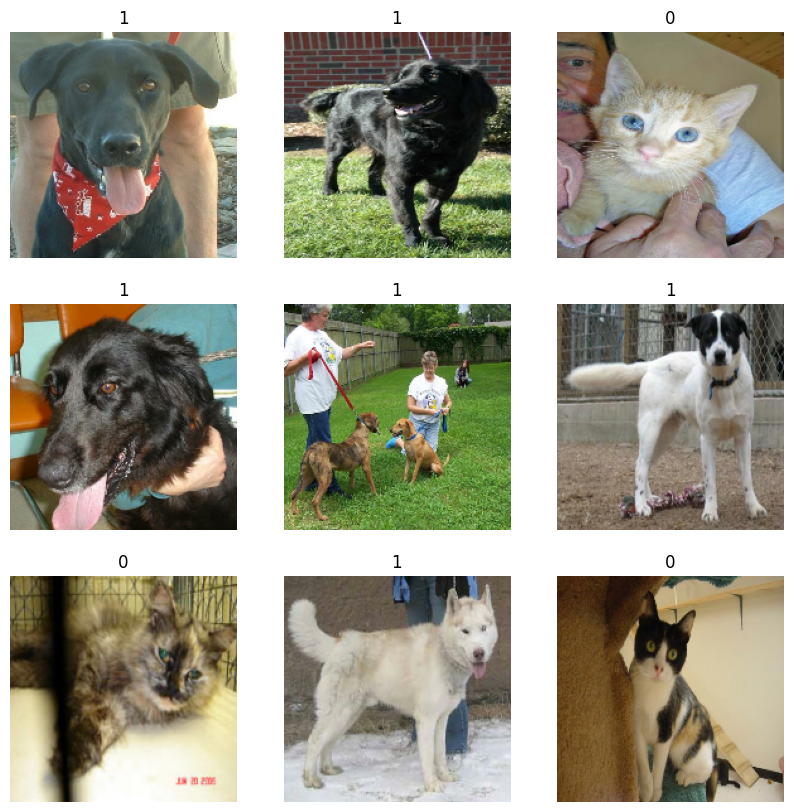

In [7]:
#Data Visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [8]:
#Image data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

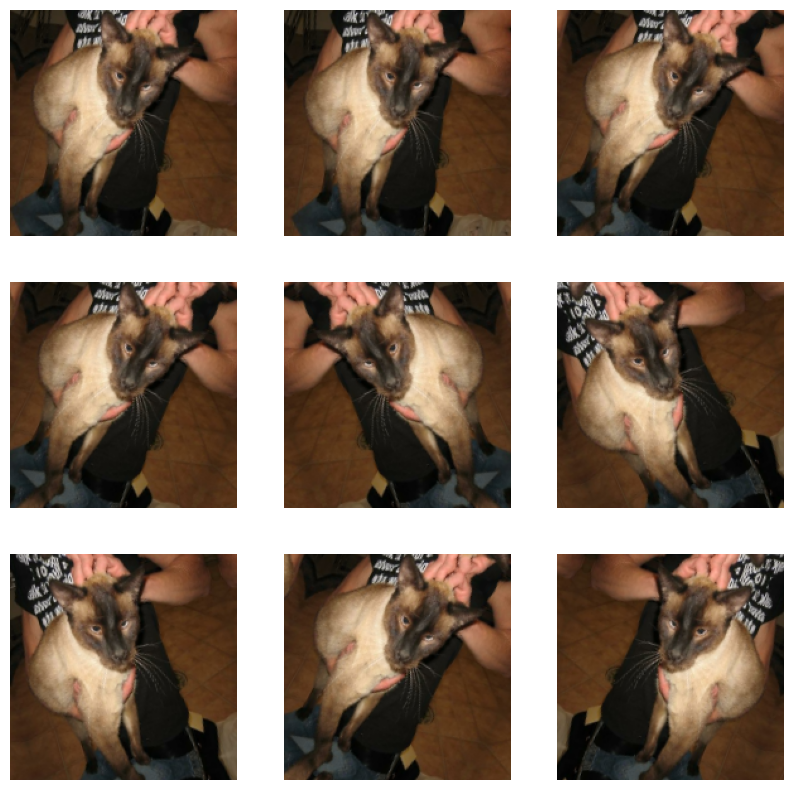

In [9]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [10]:
#Data standardization
augmented_train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x,training=True),y)
)

In [11]:
#Applying data augmentation to the training images

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img),label),
    num_parallel_calls = tf.data.AUTOTUNE,
)

#Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

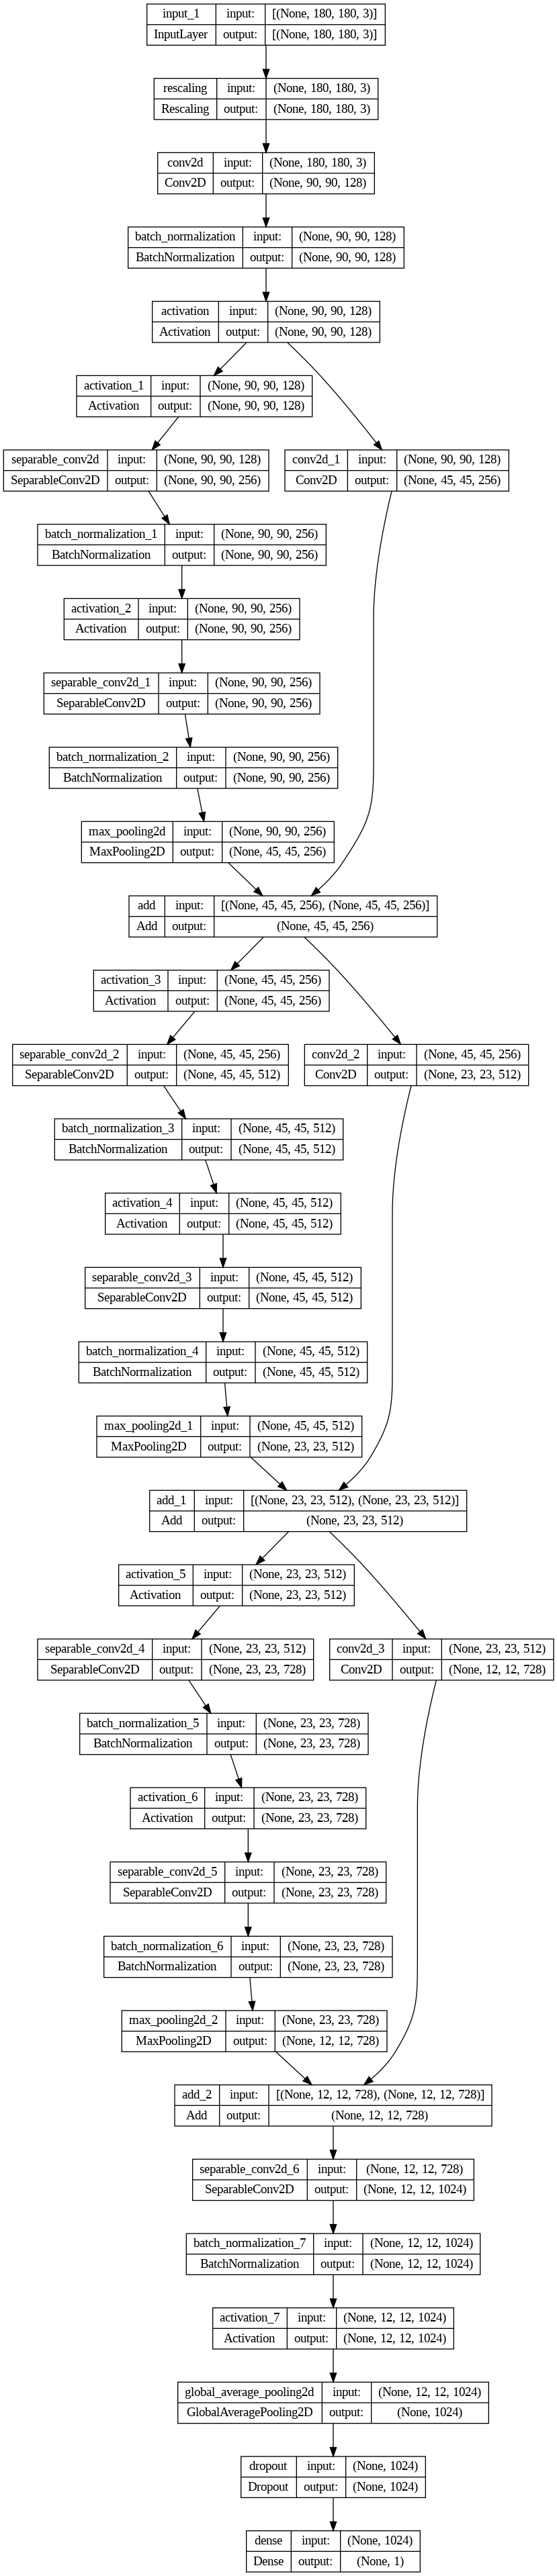

In [12]:
#Building the model (Xception)

def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)

  #Entry block
  x = layers.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  previous_block_activation = x

  for size in [256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    #Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding='same')(
        previous_block_activation
    )
    x = layers.add([x, residual])
    previous_block_activation = x

  x = layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
        activation = "sigmoid"
        units = 1
  else:
        activation = "softmax"
        units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [13]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
147/147 [==============================] - 264s 2s/step - loss: 0.6349 - accuracy: 0.6565 - val_loss: 0.8034 - val_accuracy: 0.4957
Epoch 2/10
147/147 [==============================] - 222s 1s/step - loss: 0.4671 - accuracy: 0.7780 - val_loss: 1.2385 - val_accuracy: 0.4957
Epoch 3/10
147/147 [==============================] - 221s 1s/step - loss: 0.3685 - accuracy: 0.8370 - val_loss: 1.4179 - val_accuracy: 0.4957
Epoch 4/10
147/147 [==============================] - 228s 2s/step - loss: 0.3171 - accuracy: 0.8637 - val_loss: 0.4569 - val_accuracy: 0.7666
Epoch 5/10
147/147 [==============================] - 228s 2s/step - loss: 0.2626 - accuracy: 0.8916 - val_loss: 0.2800 - val_accuracy: 0.8874
Epoch 6/10
147/147 [==============================] - 228s 2s/step - loss: 0.2278 - accuracy: 0.9045 - val_loss: 0.7701 - val_accuracy: 0.7091
Epoch 7/10
147/147 [==============================] - 228s 2s/step - loss: 0.2039 - accuracy: 0.9173 - val_loss: 0.2410 - val_accuracy: 0.8960

In [20]:
img = keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 20ms/step
This image is 99.74% cat and 0.26% dog.
